In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import pickle

In [5]:
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

In [6]:

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [7]:
from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

In [60]:
with open('all_jets_train_4D_100_percent.pkl', 'rb') as f:
    data = pickle.load(f)
x_train = data[['m','pt', 'phi','eta' ]]
x_train = (x_train - np.mean(data))/np.std(data)
x_train = x_train.astype('float32')
x_train

,m,pt,phi,eta
132784,-0.688499,-0.607632,0.868110,0.759044
99666,-0.587360,-0.612675,-1.487541,0.117475
26629,1.051901,1.503486,-1.081406,0.773109
80473,0.788040,1.697710,-0.911072,1.813980
48229,-0.578695,-0.628719,1.619716,-0.830119
...,...,...,...,...
53491,-0.537382,-0.571193,-1.193358,1.110848
106817,0.634303,0.533335,1.351926,1.069935
61324,-0.453701,-0.576950,0.679286,1.020823
132003,-0.619833,-0.587076,-1.330773,0.765245


In [9]:
with open('all_jets_test_4D_100_percent.pkl', 'rb') as g:
    data1 = pickle.load(g)

In [36]:
x_test = data1[['m','pt', 'phi','eta' ]]
x_plot = data1[['m','pt', 'phi','eta' ]]
x_test = (x_test - np.mean(data1))/np.std(data1)
x_test = x_test.astype('float32')

In [11]:
n_features = len(data.loc[0])

In [12]:
y_train = x_train
y_test = x_test

In [13]:
train_ds = TensorDataset(torch.tensor(x_train.values), torch.tensor(y_train.values))
valid_ds = TensorDataset(torch.tensor(x_test.values), torch.tensor(y_test.values))

In [14]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [15]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

In [16]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [17]:
db
input_size = 4

In [18]:
class NeuralNet(nn.Module):
    def __init__(self,input_size):
        super(NeuralNet,self).__init__()
        self.dc1 = nn.Linear(input_size,60)
        self.dc2 = nn.Linear(60,30)
        self.dc3 = nn.Linear(30,15)
        self.dc4 = nn.Linear(15,9)
        self.dc5 = nn.Linear(9,3)
        self.dc6 = nn.Linear(3,9)
        self.dc7 = nn.Linear(9,15)
        self.dc8 = nn.Linear(15,30)
        self.dc9 = nn.Linear(30,60)
        self.dc10 = nn.Linear(60,4)
        self.lrelu = nn.LeakyReLU(0.01)
        
    
    def forward(self,x):
        out = self.dc1(x)
        out = self.lrelu(out)
        out = self.dc2(out)
        out = self.lrelu(out)
        out = self.dc3(out)
        out = self.lrelu(out)
        out = self.dc4(out)
        out = self.lrelu(out)
        out = self.dc5(out)
        out = self.lrelu(out)
        out = self.dc6(out)
        out = self.lrelu(out)
        out = self.dc7(out)
        out = self.lrelu(out)
        out = self.dc8(out)
        out = self.lrelu(out)
        out = self.dc9(out)
        out = self.lrelu(out)
        out = self.dc10(out)
        out = self.lrelu(out)
        return out
        

In [19]:
model = NeuralNet(input_size)

In [20]:
criterion = nn.MSELoss()

In [21]:
bn_wd = False  
true_wd = True  
wd = 1e-6
learn = basic_train.Learner(data=db, model=model, loss_func=criterion, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

In [22]:
from fastai import train as tr
tr.lr_find(learn)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


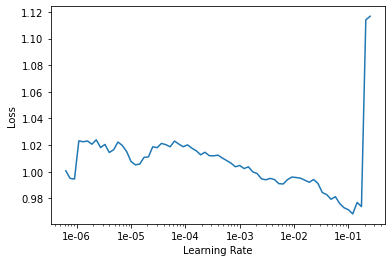

In [23]:
learn.recorder.plot()

In [24]:
lr = 1e-2
learn.fit(15, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.248987,0.213699,00:03
1,0.147864,0.134662,00:03
2,0.121058,0.109129,00:03
3,0.044048,0.042423,00:03
4,0.036810,0.038403,00:02
5,0.029069,0.028022,00:03
6,0.029468,0.026264,00:03
7,0.027241,0.025726,00:03
8,0.025665,0.022237,00:03
9,0.027898,0.022638,00:03


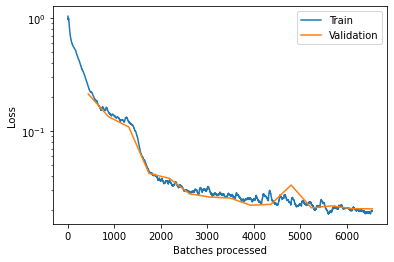

In [56]:

learn.recorder.plot_losses()
plt.yscale('log')
plt.savefig('train_loss')

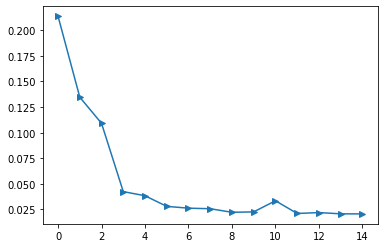

In [54]:

plt.plot(learn.recorder.val_losses, marker='>')
plt.savefig('valid_loss')

In [58]:
 ActivationStats(learn)
 print(model)

NeuralNet(
  (dc1): Linear(in_features=4, out_features=60, bias=True)
  (dc2): Linear(in_features=60, out_features=30, bias=True)
  (dc3): Linear(in_features=30, out_features=15, bias=True)
  (dc4): Linear(in_features=15, out_features=9, bias=True)
  (dc5): Linear(in_features=9, out_features=3, bias=True)
  (dc6): Linear(in_features=3, out_features=9, bias=True)
  (dc7): Linear(in_features=9, out_features=15, bias=True)
  (dc8): Linear(in_features=15, out_features=30, bias=True)
  (dc9): Linear(in_features=30, out_features=60, bias=True)
  (dc10): Linear(in_features=60, out_features=4, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
)


In [32]:
train_mean = data.mean()
train_std = data.std()
a = train_std.item()
idxs = (0, 100000)  
data = torch.tensor(x_test[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.item())
pred = np.add(pred, train_mean.item())
data = np.multiply(data, train_std.item())
data = np.add(data, train_mean.item())

In [33]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

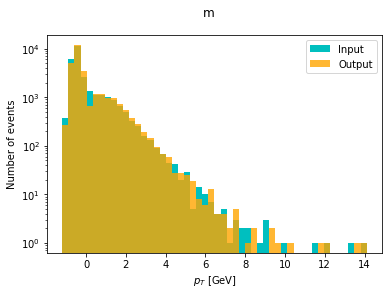

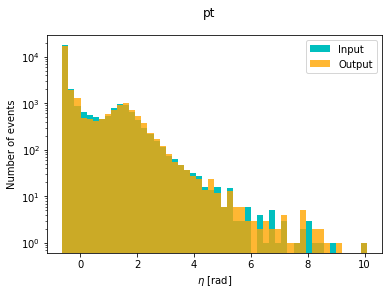

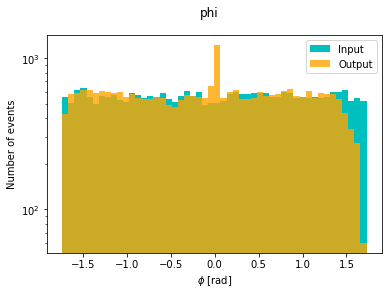

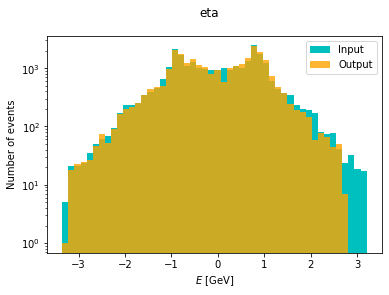

In [53]:
alph = 0.8
n_bins = 50
for kk in range(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(x_train.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    plt.yscale('log')
    plt.legend()
    plt.savefig('hist4')
    fig_name = 'trainforever_hist_%s' % data[kk,:]
    

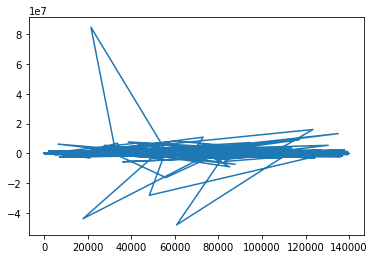

In [43]:
data = np.array(data)
plt.plot( (data[:,0]-x_plot.iloc[:,0])/data[:,0])
plt.savefig('first')

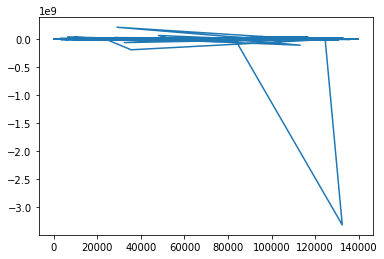

In [44]:
data = np.array(data)
plt.plot( (data[:,1]-x_plot.iloc[:,1])/data[:,1])
plt.savefig('second')

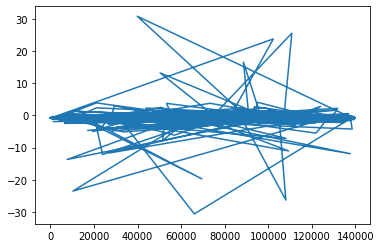

In [45]:
data = np.array(data)
plt.plot( (data[:,2]-x_plot.iloc[:,2])/data[:,2])
plt.savefig('third')

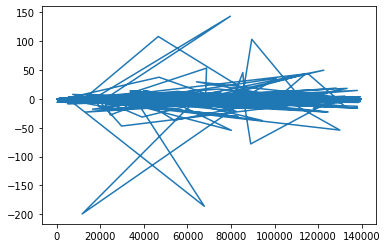

In [46]:
data = np.array(data)
plt.plot( (data[:,3]-x_plot.iloc[:,3])/data[:,3])
plt.savefig('fourth')